In [ ]:
import numpy as np
from keras.preprocessing import image
from keras import Model, models, Input
from keras import layers
from keras import optimizers

from tqdm.notebook import tqdm
import seaborn as sns

import os

from keras.datasets import cifar10

In [ ]:
RANDOM_SEED = 1
np.random.seed(1)

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [ ]:
X_train.shape

(50000, 32, 32, 3)

In [ ]:
np.unique(y_train, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

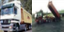

In [ ]:
image.array_to_img(np.concatenate([X_train[1], X_train[2]], axis = 1))

In [ ]:
# обираємо зображення класу собак
X_train = X_train[y_train.flatten() == 5]
X_train = X_train / 255

In [ ]:
# функція для зображення із масштабом
def plot_img(img, size = (128, 128)):
    if img.shape == size:
        return image.array_to_img(img)
    else:
        return image.array_to_img(img).resize(size)

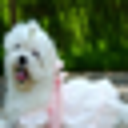

In [ ]:
plot_img(X_train[129])

# Simple GAN

In [ ]:
def get_generator(latent_dim, channels = 3):
    generator = models.Sequential()
#     generator.add(layers.Flatten(input_shape = input_dim))
    generator.add(layers.Dense(128 * 16 * 16, input_shape = (latent_dim, )))
    generator.add(layers.LeakyReLU())
    generator.add(layers.Reshape((16, 16, 128)))
    
    generator.add(layers.Conv2D(256, 5, padding = 'same'))
    generator.add(layers.LeakyReLU())
    
    generator.add(layers.Conv2DTranspose(256, 4, strides = 2, padding = 'same'))
    generator.add(layers.LeakyReLU())
    
    generator.add(layers.Conv2D(256, 5, padding = 'same'))
    generator.add(layers.LeakyReLU())
    
    generator.add(layers.Conv2D(256, 5, padding = 'same'))
    generator.add(layers.LeakyReLU())
    
    generator.add(layers.Conv2D(channels, 7, padding = 'same', activation = 'tanh'))
    
    # generator.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')



    # generator_input = Input(shape=(latent_dim,))
    # x = layers.Dense(128 * 16 * 16)(generator_input)
    # x = layers.LeakyReLU()(x)
    # x = layers.Reshape((16, 16, 128))(x)
    # x = layers.Conv2D(256, 5, padding='same')(x)
    # x = layers.LeakyReLU()(x)
    # x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    # x = layers.LeakyReLU()(x)
    # x = layers.Conv2D(256, 5, padding='same')(x)
    # x = layers.LeakyReLU()(x)
    # x = layers.Conv2D(256, 5, padding='same')(x)
    # x = layers.LeakyReLU()(x)
    # x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
    # generator = models.Model(generator_input, x)

    
    return generator

In [ ]:
get_generator(32).summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_146 (LeakyReLU)  (None, 32768)             0         
_________________________________________________________________
reshape_15 (Reshape)         (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_147 (LeakyReLU)  (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 32, 32, 256)       1048832   
_________________________________________________________________
leaky_re_lu_148 (LeakyReLU)  (None, 32, 32, 256)     

In [ ]:
def get_discriminator(input_shape):
    disc = models.Sequential()
    disc.add(layers.Conv2D(128, 3, input_shape = input_shape))
    disc.add(layers.LeakyReLU())
    disc.add(layers.Conv2D(128, 4, strides = 2))
    disc.add(layers.LeakyReLU())
    disc.add(layers.Conv2D(128, 4, strides = 2))
    disc.add(layers.LeakyReLU())
    disc.add(layers.Conv2D(128, 4, strides = 2))
    disc.add(layers.LeakyReLU())
    
    disc.add(layers.Flatten())
    
    disc.add(layers.Dropout(0.4))
  
    disc.add(layers.Dense(1, activation = 'sigmoid'))
    
    optimizer = optimizers.RMSprop(learning_rate=0.0008, clipvalue = 1.0, decay = 1e-8)
    disc.compile(loss = 'binary_crossentropy', optimizer = optimizer)
    
    return disc

In [ ]:
get_discriminator((32, 32, 3)).summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_135 (Conv2D)          (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_152 (LeakyReLU)  (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_153 (LeakyReLU)  (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_154 (LeakyReLU)  (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 2, 2, 128)       

In [ ]:
def get_gan_nn(generator, discriminator, latent_dim):
    discriminator.trainable = False
    input_layer = layers.Input(shape = (latent_dim, ))
    output = discriminator(generator(input_layer))

    model = Model(inputs = input_layer, outputs = output)

    optimizer = optimizers.RMSprop(learning_rate=0.0004, clipvalue = 1.0, decay = 1e-8)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer)    

    return model

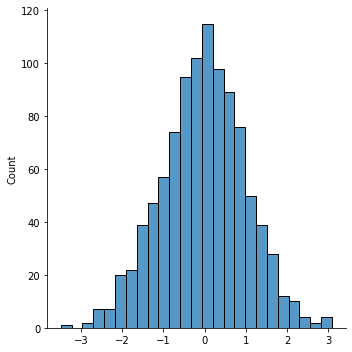

In [ ]:
sns.displot(np.random.normal(size = 1000))

In [ ]:
def train_model(data, generator, descriminator, gan, epochs = 1, start_epoch = 1, 
                batch_size = 128, save_samples = True, 
                save_models_dir = '/content/save_data', 
                save_img_dir = '/content/save_data/images'):
  
    print(f"Data shape: {data.shape}\n")
    batch_count = data.shape[0] // batch_size

    d_loss = list()
    g_loss = list()
    
    for epoch in range(start_epoch, start_epoch + epochs):
        print(f"{'-' * 15} Epoch: {epoch}/{start_epoch + epochs - 1} {'-' * 15}")
        
        for i in tqdm(range(batch_count)):
            input_val = np.random.normal(size = (batch_size, generator.input.shape[1]))
            
            # preparing data
            data_batch = data[i * batch_size : (i + 1) * batch_size]
            generated_data = generator.predict(input_val)
            X = np.concatenate([data_batch, generated_data])
            y = np.zeros(X.shape[0])
            y[:batch_size] = 1
            y += 0.05 * np.random.rand(len(y)) - 0.025
            
            # train discriminator
            discriminator.trainable = True
            loss = discriminator.train_on_batch(X, y)
            d_loss.append(loss)
            
            # train gan model
            input_val = np.random.normal(size = (batch_size, generator.input.shape[1]))
            y = np.ones(batch_size)
            discriminator.trainable = False
            loss = gan.train_on_batch(input_val, y)
            g_loss.append(loss)

            # logs and saving data
            step = batch_count // 3
            if (i + 1) % step == 0:
              print(f"Iteration: {i} \t Discriminator loss: {round(np.mean(d_loss), 3)}, \t Gan loss: {round(np.mean(g_loss), 3)}")
              image.save_img(os.path.join(save_img_dir, f"real_img.Epoch{epoch}({i // step}).png"),
                             data_batch[0])
              image.save_img(os.path.join(save_img_dir, f"generated_img.Epoch{epoch}({i // step}).png"),
                             generated_data[0])
              d_loss.clear()
              g_loss.clear()

        # save models
        if (epoch % 10) == 0:
            generator.save(os.path.join(save_models_dir, f"generator.epoch{epoch}.h5"))
            discriminator.save(os.path.join(save_models_dir, f"discriminator.epoch{epoch}.h5"))
            gan.save(os.path.join(save_models_dir, f"gan_model.epoch{epoch}.h5"))
            print(f"Epoch {epoch}. Models saved\n")

In [ ]:
generator = get_generator(32)
discriminator = get_discriminator((32, 32, 3))
gan = get_gan_nn(generator, discriminator, 32)

In [ ]:
%%time
train_model(X_train, 
            generator, 
            discriminator, 
            gan,
            epochs = 20, 
            start_epoch = 131, 
            batch_size = 20, 
            save_models_dir = '/content/simple_GAN.model4',
            save_img_dir = '/content/simple_GAN.model4/images')

Data shape: (5000, 32, 32, 3)

--------------- Epoch: 131/150 ---------------


Iteration: 82 	 Discriminator loss: 0.647, 	 Gan loss: 0.991
Iteration: 165 	 Discriminator loss: 0.657, 	 Gan loss: 0.993
Iteration: 248 	 Discriminator loss: 0.695, 	 Gan loss: 0.983

Epoch 131. Models saved

--------------- Epoch: 132/150 ---------------


Iteration: 82 	 Discriminator loss: 0.647, 	 Gan loss: 1.044
Iteration: 165 	 Discriminator loss: 0.65, 	 Gan loss: 1.014
Iteration: 248 	 Discriminator loss: 0.657, 	 Gan loss: 1.018

Epoch 132. Models saved

--------------- Epoch: 133/150 ---------------


Iteration: 82 	 Discriminator loss: 0.645, 	 Gan loss: 1.019
Iteration: 165 	 Discriminator loss: 0.645, 	 Gan loss: 1.034
Iteration: 248 	 Discriminator loss: 0.657, 	 Gan loss: 1.022

Epoch 133. Models saved

--------------- Epoch: 134/150 ---------------


Iteration: 82 	 Discriminator loss: 0.657, 	 Gan loss: 1.045
Iteration: 165 	 Discriminator loss: 0.653, 	 Gan loss: 1.037
Iteration: 248 	 Discriminator loss: 0.649, 	 Gan loss: 1.033

Epoch 134. Models saved

--------------- Epoch: 135/150 ---------------


Iteration: 82 	 Discriminator loss: 0.634, 	 Gan loss: 1.048
Iteration: 165 	 Discriminator loss: 0.645, 	 Gan loss: 1.046
Iteration: 248 	 Discriminator loss: 0.645, 	 Gan loss: 1.043

Epoch 135. Models saved

--------------- Epoch: 136/150 ---------------


Iteration: 82 	 Discriminator loss: 0.637, 	 Gan loss: 1.082
Iteration: 165 	 Discriminator loss: 0.66, 	 Gan loss: 1.042
Iteration: 248 	 Discriminator loss: 0.648, 	 Gan loss: 1.027

Epoch 136. Models saved

--------------- Epoch: 137/150 ---------------


Iteration: 82 	 Discriminator loss: 0.651, 	 Gan loss: 1.062
Iteration: 165 	 Discriminator loss: 0.651, 	 Gan loss: 1.055
Iteration: 248 	 Discriminator loss: 0.652, 	 Gan loss: 1.007

Epoch 137. Models saved

--------------- Epoch: 138/150 ---------------


Iteration: 82 	 Discriminator loss: 0.627, 	 Gan loss: 1.107
Iteration: 165 	 Discriminator loss: 0.64, 	 Gan loss: 1.054
Iteration: 248 	 Discriminator loss: 0.639, 	 Gan loss: 1.04

Epoch 138. Models saved

--------------- Epoch: 139/150 ---------------


Iteration: 82 	 Discriminator loss: 0.637, 	 Gan loss: 1.064
Iteration: 165 	 Discriminator loss: 0.636, 	 Gan loss: 1.081
Iteration: 248 	 Discriminator loss: 0.636, 	 Gan loss: 1.079

Epoch 139. Models saved

--------------- Epoch: 140/150 ---------------


Iteration: 82 	 Discriminator loss: 0.641, 	 Gan loss: 1.071
Iteration: 165 	 Discriminator loss: 0.631, 	 Gan loss: 1.105
Iteration: 248 	 Discriminator loss: 0.626, 	 Gan loss: 1.077

Epoch 140. Models saved

--------------- Epoch: 141/150 ---------------


Iteration: 82 	 Discriminator loss: 0.629, 	 Gan loss: 1.096
Iteration: 165 	 Discriminator loss: 0.639, 	 Gan loss: 1.079
Iteration: 248 	 Discriminator loss: 0.644, 	 Gan loss: 1.093

Epoch 141. Models saved

--------------- Epoch: 142/150 ---------------


Iteration: 82 	 Discriminator loss: 0.61, 	 Gan loss: 1.138
Iteration: 165 	 Discriminator loss: 0.631, 	 Gan loss: 1.116
Iteration: 248 	 Discriminator loss: 0.628, 	 Gan loss: 1.142

Epoch 142. Models saved

--------------- Epoch: 143/150 ---------------


Iteration: 82 	 Discriminator loss: 0.634, 	 Gan loss: 1.132
Iteration: 165 	 Discriminator loss: 0.625, 	 Gan loss: 1.195
Iteration: 248 	 Discriminator loss: 0.633, 	 Gan loss: 1.102

Epoch 143. Models saved

--------------- Epoch: 144/150 ---------------


Iteration: 82 	 Discriminator loss: 0.635, 	 Gan loss: 1.118
Iteration: 165 	 Discriminator loss: 0.625, 	 Gan loss: 1.114
Iteration: 248 	 Discriminator loss: 0.63, 	 Gan loss: 1.088

Epoch 144. Models saved

--------------- Epoch: 145/150 ---------------


Iteration: 82 	 Discriminator loss: 0.613, 	 Gan loss: 1.129
Iteration: 165 	 Discriminator loss: 0.609, 	 Gan loss: 1.216
Iteration: 248 	 Discriminator loss: 0.631, 	 Gan loss: 1.125

Epoch 145. Models saved

--------------- Epoch: 146/150 ---------------


Iteration: 82 	 Discriminator loss: 0.628, 	 Gan loss: 1.171
Iteration: 165 	 Discriminator loss: 0.631, 	 Gan loss: 1.172
Iteration: 248 	 Discriminator loss: 0.625, 	 Gan loss: 1.096

Epoch 146. Models saved

--------------- Epoch: 147/150 ---------------


Iteration: 82 	 Discriminator loss: 0.612, 	 Gan loss: 1.192
Iteration: 165 	 Discriminator loss: 0.627, 	 Gan loss: 1.332
Iteration: 248 	 Discriminator loss: 0.602, 	 Gan loss: 1.237

Epoch 147. Models saved

--------------- Epoch: 148/150 ---------------


Iteration: 82 	 Discriminator loss: 0.619, 	 Gan loss: 1.183
Iteration: 165 	 Discriminator loss: 0.615, 	 Gan loss: 1.198
Iteration: 248 	 Discriminator loss: 0.614, 	 Gan loss: 1.204

Epoch 148. Models saved

--------------- Epoch: 149/150 ---------------


Iteration: 82 	 Discriminator loss: 0.594, 	 Gan loss: 1.218
Iteration: 165 	 Discriminator loss: 0.615, 	 Gan loss: 1.223
Iteration: 248 	 Discriminator loss: 0.618, 	 Gan loss: 1.155

Epoch 149. Models saved

--------------- Epoch: 150/150 ---------------


Iteration: 82 	 Discriminator loss: 0.607, 	 Gan loss: 1.221
Iteration: 165 	 Discriminator loss: 0.613, 	 Gan loss: 1.193
Iteration: 248 	 Discriminator loss: 0.616, 	 Gan loss: 1.162

Epoch 150. Models saved

CPU times: user 6min 32s, sys: 18.4 s, total: 6min 50s
Wall time: 10min 40s


In [ ]:
generator.save('generator.epoch150.h5')

In [ ]:
generator.save_weights('generator_weights.epoch21.h5')

In [ ]:
discriminator.save("discriminator.epoch150.h5")

In [ ]:
gan.save('gan_model.epoch150.h5')

In [ ]:
!zip -r "simple_GAN.4model.zip" "/content/simple_GAN.model4/images"

In [ ]:
input_val = np.random.normal(size = (3, 32))
# input_val = input_val * 1000
# # input_val = input_val * np.random.rand(32)
# input_val[0][10] = 1
# input_val[0][11] = 1
# input_val[0][12] = 1
# input_val[0][13] = 1
# input_val[0][14] = 1
# input_val[0][15] = 1
# input_val[0][2] = 0
# input_val[0][3] = 0
# input_val[0][3] = 0
# input_val[0][4] = 0
# input_val[0][5] = 0
# input_val[0][6] = 0

input_val[0]

array([-0.18198567, -2.45931807, -0.59560837, -0.25459864, -1.00747673,
        1.60359557, -0.61660449, -0.36861477,  0.91943906, -0.15588489,
        0.32733496, -0.75714608, -1.04002725,  0.73520595,  2.26852298,
       -1.33142166,  1.01249283,  0.79499484, -0.50542047,  0.44421518,
        0.71004878,  0.30364762, -0.84252821,  1.01472054, -0.80920794,
        1.05918216, -1.34426269, -1.60756762,  0.37349709,  0.15289545,
       -0.59872691,  0.87843869])

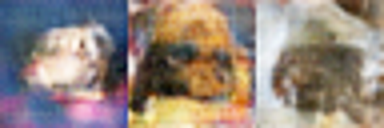

In [ ]:
generated_data = generator.predict(input_val)
# plot_img(generated_data[0])
plot_img(np.concatenate(generated_data, axis = 1), size = (128 * 3, 128))

In [ ]:
cop = generated_data[0].copy()

In [ ]:
cop[0][0]

In [ ]:
generated_data[0][0][0]

In [ ]:
np.invert(np.logical_not(generated_data[0] == cop))